# Imports

To install the required dependencies, launch the `.bat` file at the root of the project.


In [13]:
from warnings import filterwarnings

filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from portfolio_management.beta_estimation import beta_convergence
from utility.types import (
    RebalanceFrequencyEnum,
    RegimeDetectionModels,
)
from portfolio_management.market_regime import detect_market_regime
from data.universe import Universe
from data.benchmark import Benchmark
from backtest.backtest import Backtester

# Benchmark computing

Use the constructor of the class in order to build the Benchmark object and the performances/returns associated with. The benchmark is only composed of the SX5T, SPTR500N and ESTR. The proportion are as the following:
$$\text{Benchmark} = \text{SPTR500N}\times20\% + \text{ESTR}\times30\% + \text{SX5T}\times50\%$$


2010-07-06    1.000000
2010-07-07    1.012581
2010-07-08    1.022327
2010-07-09    1.027024
2010-07-12    1.030051
                ...   
2024-03-01    2.073689
2024-03-04    2.079164
2024-03-05    2.073590
2024-03-06    2.074361
2024-03-07    2.086805
Freq: B, Name: benchmark_perf, Length: 3568, dtype: float64

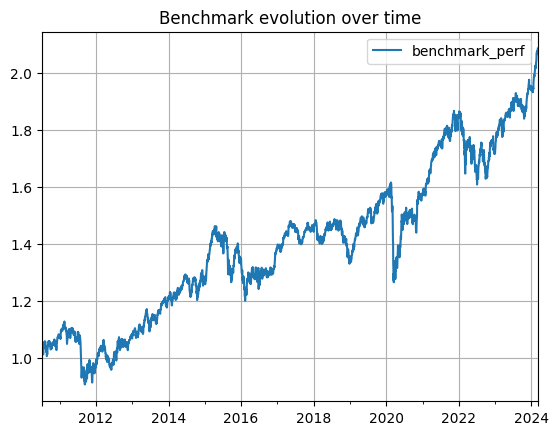

In [14]:
bench_obj = Benchmark(
    RebalanceFrequencyEnum.MONTH_END
)  # Create the benchmark with a monthly rebalance frequency


bench_obj.benchmark_perf.plot(
    grid=True, legend=True, title="Benchmark evolution over time"
)

bench_obj.benchmark_perf

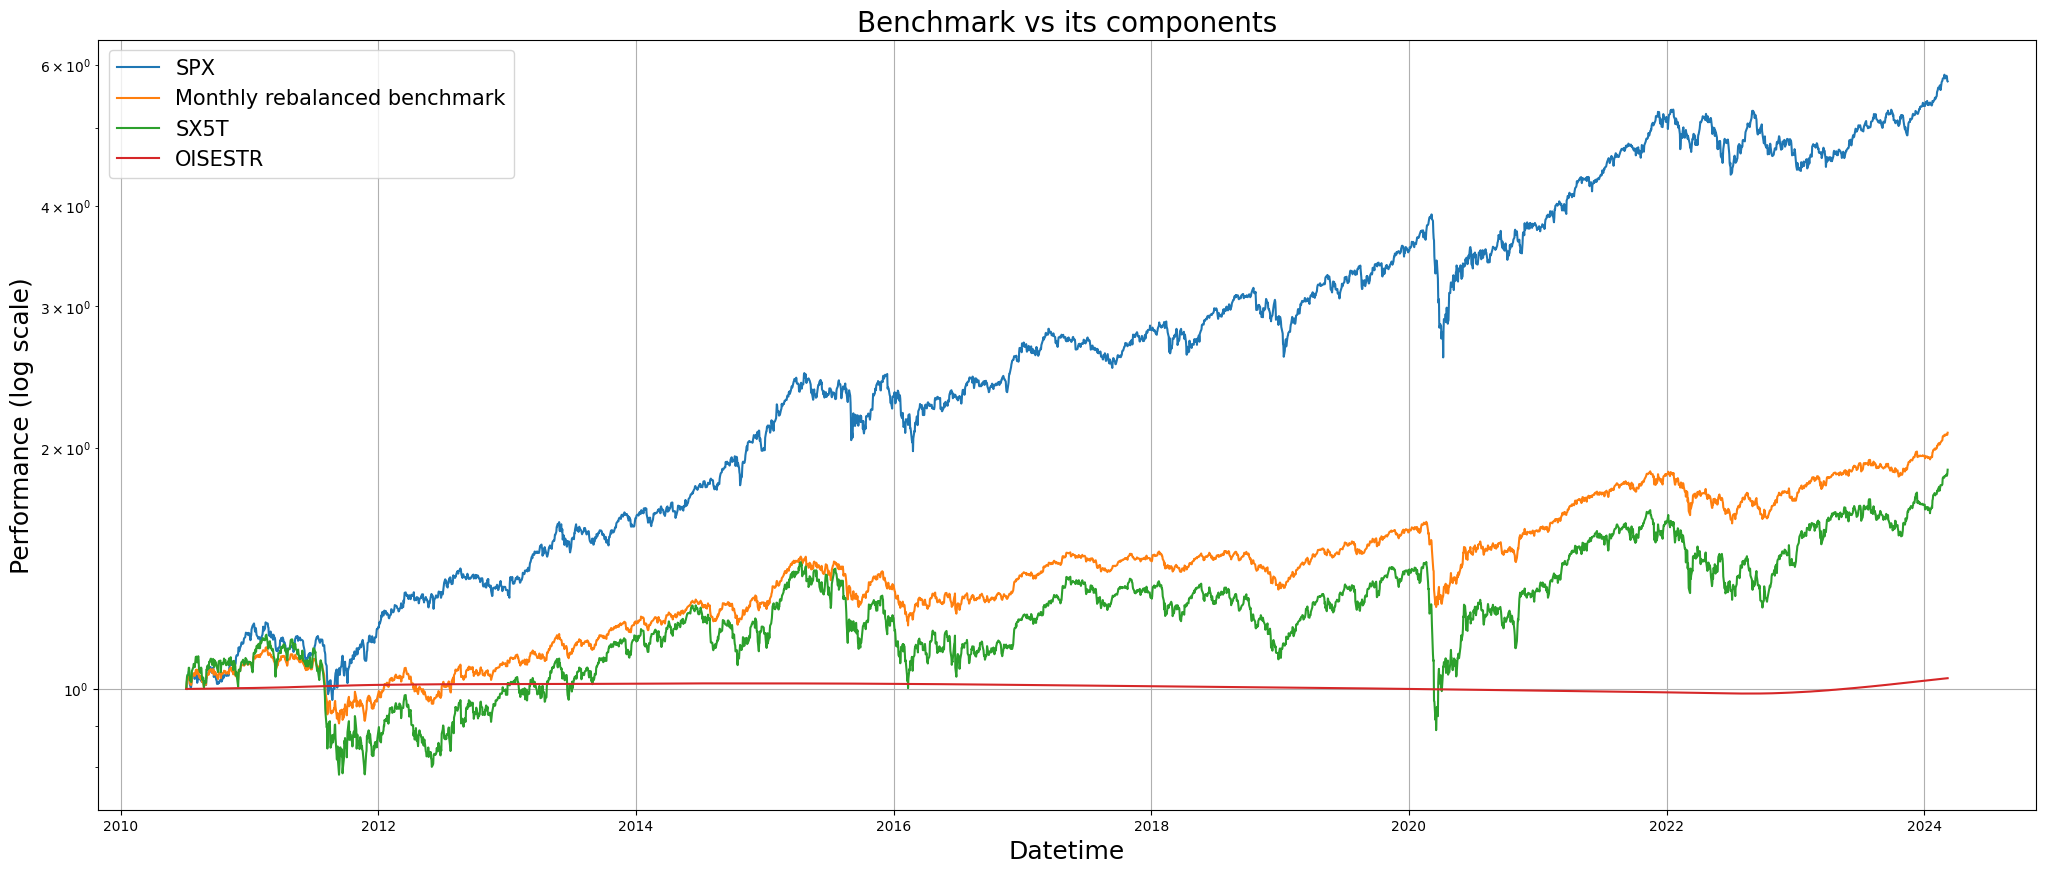

In [15]:
component = bench_obj.get_benchmark_returns_data()
plt.figure(figsize=(25, 10))
plt.plot((component["SPX"] + 1).cumprod(), label="SPX")

plt.plot(bench_obj.benchmark_perf, label="Monthly rebalanced benchmark")
plt.plot((component["SX5T"] + 1).cumprod(), label="SX5T")
plt.plot((component["OISESTR"] + 1).cumprod(), label="OISESTR")
plt.yscale("log")
plt.xlabel("Datetime", fontsize=18)
plt.ylabel("Performance (log scale)", fontsize=18)
plt.title("Benchmark vs its components", fontsize=20)
plt.grid()
plt.legend(fontsize=15)

## Benchmark weights evolution over time


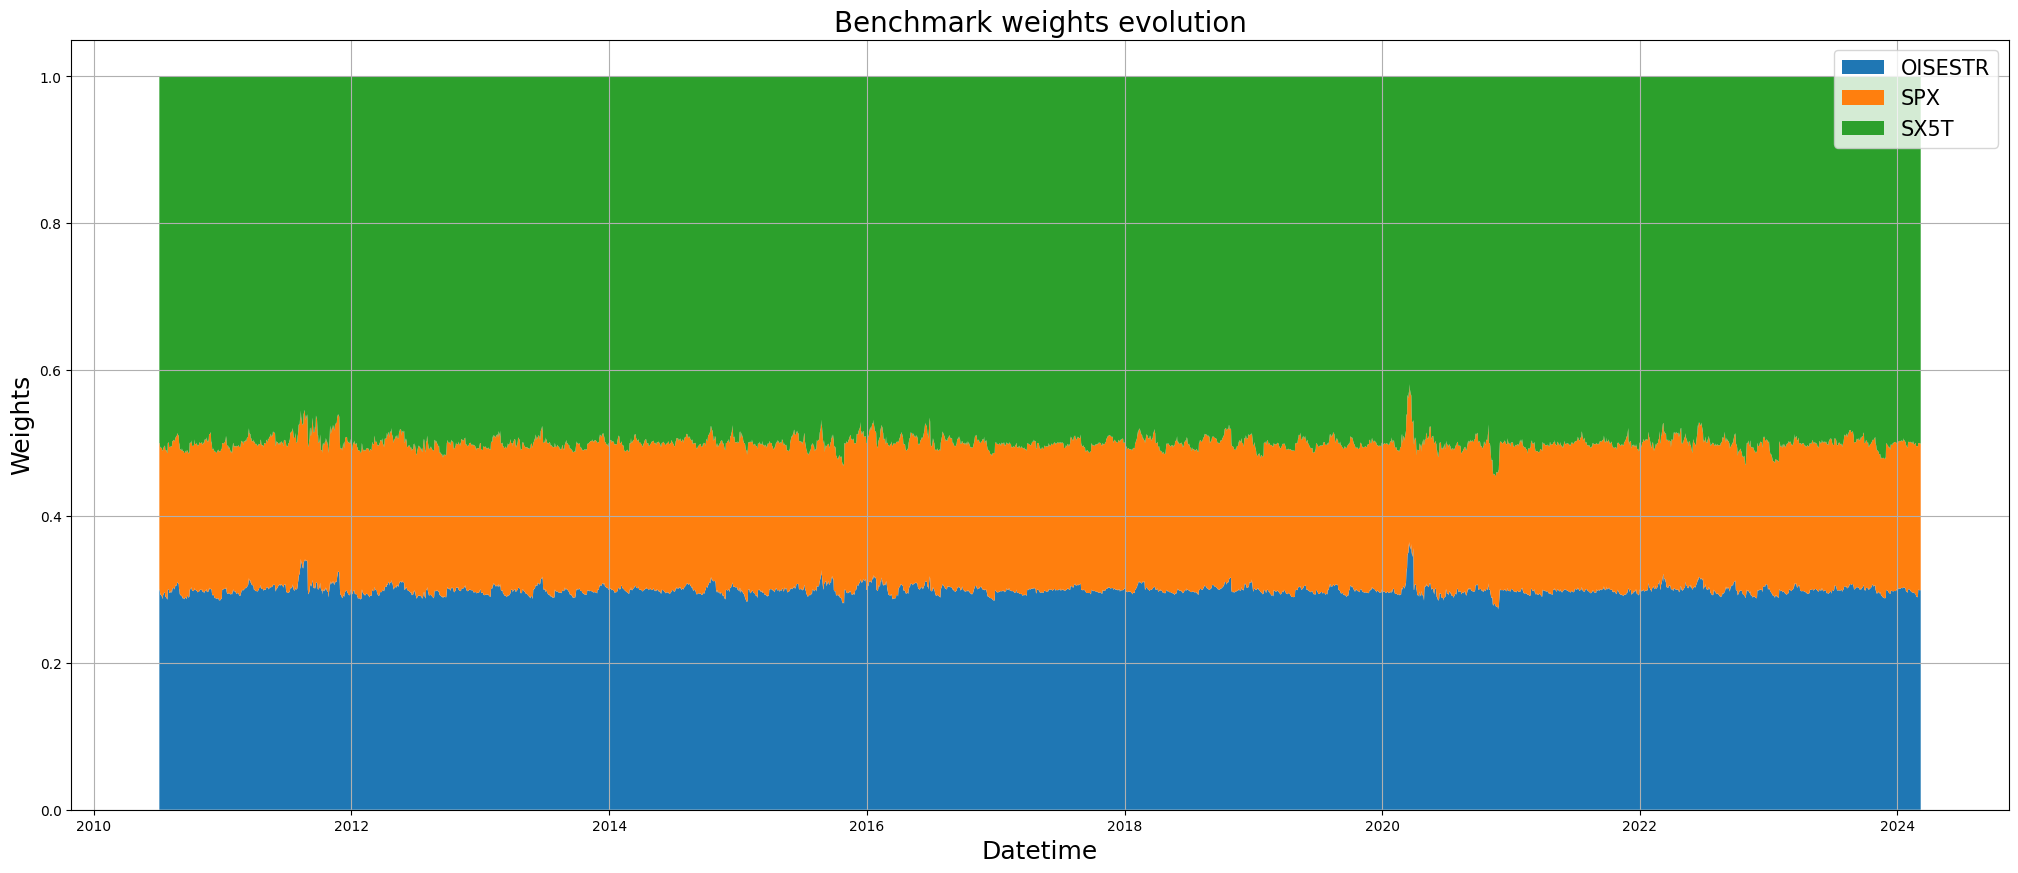

In [16]:
weights_df = bench_obj.benchmark_weights

plt.figure(figsize=(25, 10))
plt.stackplot(
    weights_df.index,
    weights_df.to_numpy().T,
)
plt.xlabel("Datetime", fontsize=18)
plt.ylabel("Weights", fontsize=18)
plt.title("Benchmark weights evolution", fontsize=20)
plt.grid()
plt.legend(weights_df.columns.to_list(), fontsize=15)
plt.show()

# Market Data and Universe

Our universe is composed of 11 assets.

Our Benchmark :

- SX5T : SX5E Total Return, AUM = 2.8MM, fees : 0.07%
- SPTR500N : SP500 Total Return, AUM = 10MM, fees : 0.07%
- ESTR_ETF : EONIA/ESTR return

Our leverage tools (futures) in order to monitor our Beta :

- futures SX5E
- futures sp500
- futures nasdaq

Thematiques ETF :

- WATER ESG : Réplique l’indice de référence MSCI ACWI IMI Water ESG Filtered Net USD Index. Cet indice vise à représenter la performance des valeurs des entreprises dans le secteur de l’eau : distribution, infrastructure, services publics équipements ou traitement de l’eau. Conçu sur une approche ESG « best in class » ; les sociétés du quartile inférieur par note ESG ajustée du secteur sont exclues de l’univers ainsi que les sociétés exposées à des activités controversées et/ou à des controverses ESG majeures.

  AUM = 1.5MM
  Fees = 0.6%

- EUROPE \_VALUE_FACTOR : Réplique l'indice de stratégie MSCI Europe Value. Cet ETF permet de suivre facilement l'évolution de près de 300 des plus importantes valeurs de 15 pays européens, représentatives des valeurs de rendement value (Une entreprise est généralement considéré comme value lorsque son stock présente un ratio (book to market/ market cap) élevé, autrement dit une valeur avec de bon fondamentaux sous évalué par le marché). on retrouve comme pondérations les plus importantes: Total, Sanofi, Shell, Novartis..

  AUM = 424 M
  Fees = 0.23%

- STOXX_EUROPE 600_TECHNOLOGY : Réplique la performance de l’Indice STOXX Europe 600 Technology qui concerne les valeurs technologiques européennes (Infineon, STMicroelectronics, Dassault...). Un ETF étant plus volatile et pouvant offrir plus de sensibilité au marché.

  AUM = 202M
  Fees = 0.3%

- STOXX_EUROPE 600_HEALTHCARE : Réplique la performance de l’Indice STOXX Europe 600 Healthcare qui concerne les valeurs dans le domaine de la santé européennes (ESSILOR LUXOTTICA, Sanofi, Novo Nordisk...). Un ETF considéré comme étant plus défensif.

  AUM = 754M
  Fees = 0.3%

- EPSILON_TREND: ETF diverisifiant multi class d'actif qui se concentre principalement sur une strategies de trend following. C'est un ETF considéré comme décorrelant par rapport aux ETF defensifs et offensifs. IE00B61N8946

  AUM = 453M
  Fees = Perf fees only


In [17]:
univ_obj = Universe(market_column="SPTR500N", keep_only_benchmark_universe=False)

universe_df = univ_obj.get_universe_returns()

universe_df

,EUROPE _VALUE_FACTOR,WATER_ESG,STOXX_EUROPE 600_TECHNOLOGY,STOXX_EUROPE 600_HEALTHCARE,EPSILON_TREND,Px fut SX5E,Px fut sp500,Px fut nasdaq,SX5T,SPTR500N,ESTR_ETF
2011-04-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-04-18,-0.019838,-0.008338,-0.015371,-0.005608,-0.023932,-0.023910,-0.013460,-0.008551,-0.024178,-0.003812,0.000045
2011-04-19,0.002565,-0.001201,-0.000905,0.003589,0.011258,0.001801,0.005765,0.009170,0.003744,0.008637,0.000045
2011-04-20,0.018252,0.011425,0.026495,0.017625,0.022580,0.023013,0.015094,0.019039,0.022820,0.000976,0.000048
2011-04-21,0.002988,0.001189,0.010368,-0.002259,0.005438,0.008436,0.002070,0.008705,0.006865,-0.002491,0.000057
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,0.004568,0.005994,0.015707,0.013283,0.003002,0.001430,0.008278,0.014129,0.001428,0.004299,0.000155
2024-03-04,-0.003465,0.003610,0.007408,0.004546,0.005692,0.003469,-0.001506,-0.004158,0.004018,0.002917,0.000155
2024-03-05,0.002646,-0.005968,-0.016467,-0.005092,0.000850,-0.004270,-0.010217,-0.018166,-0.004131,-0.003285,0.000155
2024-03-06,0.003564,0.000316,0.012498,0.001467,0.001088,0.005105,0.005112,0.006358,0.005315,-0.011630,0.000155


# Asset performance in the two regimes

We executed the algorithm in an offline way in order to have an ex-ante idea of the asset performance during the two regime


In [18]:
universe_data = universe_df.copy()


REGIMES = detect_market_regime(
    market_data=universe_data[
        ["SX5T"]
    ].to_numpy(),  # .pct_change().fillna(0).to_numpy(),
    market_regime_detection_algorithm=RegimeDetectionModels.HIDDEN_MARKOV_MODEL,
    scale_data=True,
    scaler_type="robust",
)
universe_data["REGIMES"] = REGIMES

In [19]:
(universe_data[universe_data["REGIMES"] == 0].mean() * 252).sort_values()

REGIMES                        0.000000
ESTR_ETF                       0.002778
EPSILON_TREND                  0.074194
STOXX_EUROPE 600_HEALTHCARE    0.173083
Px fut sp500                   0.207876
Px fut SX5E                    0.213355
EUROPE _VALUE_FACTOR           0.214487
SPTR500N                       0.217030
WATER_ESG                      0.221034
SX5T                           0.228830
Px fut nasdaq                  0.274195
STOXX_EUROPE 600_TECHNOLOGY    0.309476
dtype: float64

In [20]:
(universe_data[universe_data["REGIMES"] == 1].mean() * 252).sort_values()

SX5T                            -0.316378
Px fut SX5E                     -0.272458
EUROPE _VALUE_FACTOR            -0.264730
STOXX_EUROPE 600_TECHNOLOGY     -0.247317
WATER_ESG                       -0.129525
Px fut sp500                    -0.084005
SPTR500N                        -0.045971
Px fut nasdaq                   -0.041533
EPSILON_TREND                   -0.033084
STOXX_EUROPE 600_HEALTHCARE     -0.026800
ESTR_ETF                         0.000146
REGIMES                        252.000000
dtype: float64

We can hence assign a category to our universe of assets by offensive of defensive.


# Beta convergence during market regime

This chart shows the evolution of the stock exposure over time using an exponential smoothing function. The smoothing function looks like:
$$\beta_i = \frac{\beta_{final}-\beta_0}{1-e^{-\frac{\lambda}{\beta_{i-1}}}}$$
At each iteration this function uses:

- $\beta_0$ The initial beta at the beginning of the market regime
- $\beta_{i-1}$ The pervious beta calculated by this function
- $\beta_{final}$ The long term value to converge to
- $\lambda$ The smoothing coefficient

The word beta here correspond to the stock exposure and not to the real beta $\frac{cov(r_i,r_m)}{\sigma^2_{r_m}}$.


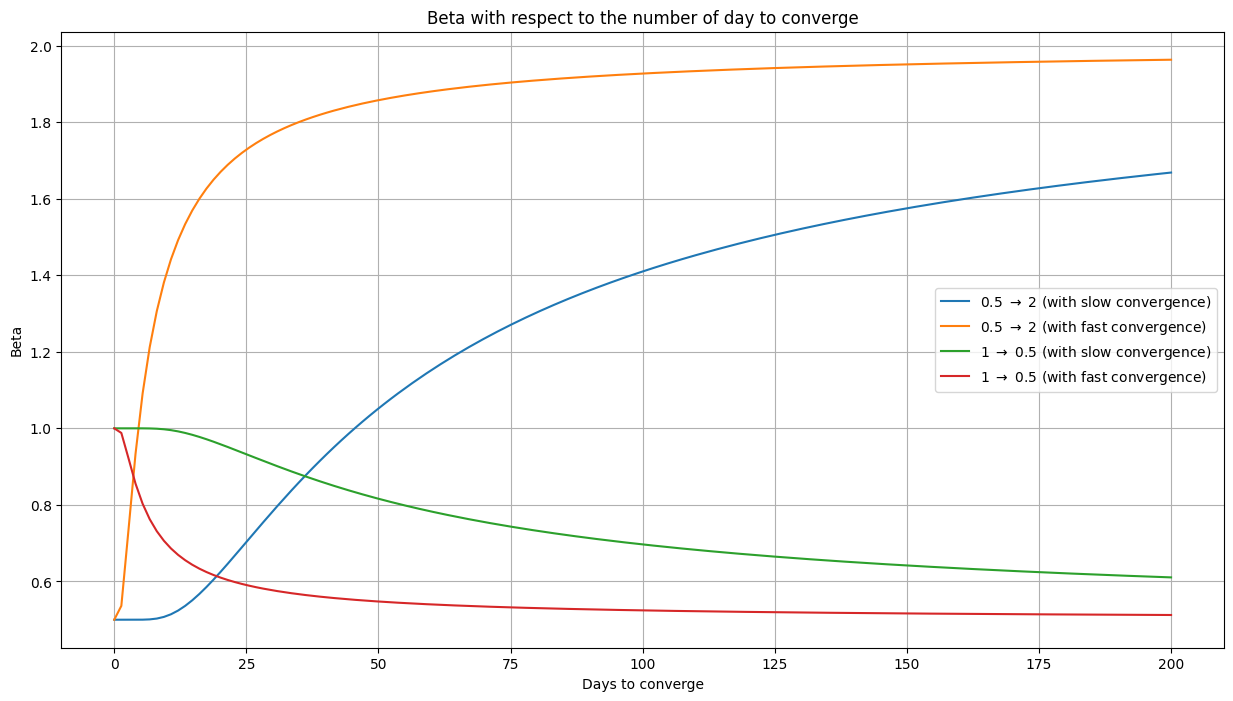

In [21]:
plt.figure(figsize=(15, 8))
plt.plot(
    np.linspace(0, 200, 150),
    beta_convergence(np.linspace(0, 200, 150), 0.5, 2, 50),
    label=r"0.5 $\rightarrow$ 2 (with slow convergence)",
)
plt.plot(
    np.linspace(0, 200, 150),
    beta_convergence(np.linspace(0, 200, 150), 0.5, 2, 5),
    label=r"0.5 $\rightarrow$ 2 (with fast convergence)",
)
plt.plot(
    np.linspace(0, 200, 150),
    beta_convergence(np.linspace(0, 200, 150), 1, 0.5, 50),
    label=r"1 $\rightarrow$ 0.5 (with slow convergence)",
)
plt.plot(
    np.linspace(0, 200, 150),
    beta_convergence(np.linspace(0, 200, 150), 1, 0.5, 5),
    label=r"1 $\rightarrow$ 0.5 (with fast convergence)",
)
plt.title("Beta with respect to the number of day to converge")
plt.xlabel("Days to converge")
plt.ylabel("Beta")
plt.grid()
plt.legend()

# Backtest & management process

Then we backtest the solution with a rebalance frequency, a regime detection frequency and a regime detection algorithm. We also have to provide a the risk off stock exposure (`risk_off_beta`) and the risk on stock exposure (`risk_on_beta`).

The class `Backtester` takes as input an instance of the class `Universe` and a series of returns corresponding to the benchmark.

## Management process

<img src="../static/img/Gestion_white.png" height="850">

## Backtest



-------  Returns statistical information  --------
Expected return annualized: 10.90 % vs 5.37 % (benchmark)
Alpha annualized: 5.83 %
CAGR: 10.77 % vs 4.97 % (benchmark)
Expected volatility annualized: 11.86 % vs 10.36 % (benchmark)
Specific volatility (diversifiable) annualized: 6.72 %
Systematic volatility annualized: 9.77 %
Skewness: -0.54 vs -0.52 (benchmark), <0 = left tail, >0 = right tail
Kurtosis: 3.42 vs -0.52 (benchmark) , >3 = fat tails, <3 = thin tails
95%-VaR: -1.25 % vs -1.04 % (benchmark) -> the lower the better
95%-CVaR: -1.84 % vs -1.59 % (benchmark) -> the lower the better

-------  Strategy statistical information  -------
Max drawdown: -22.20 % vs -21.70 % (benchmark)
Kelly criterion: 8.26 % vs 4.83 % (benchmark)
Benchmark sensitivity (beta): 0.94 vs 1 (benchmark)
Determination coefficient R²: 0.68
Tracking error annualized: 6.75 %

---------------  Strategy ratios  ----------------
No risk free rate considered for the following ratios.

Sharpe ratio annualized: 0.

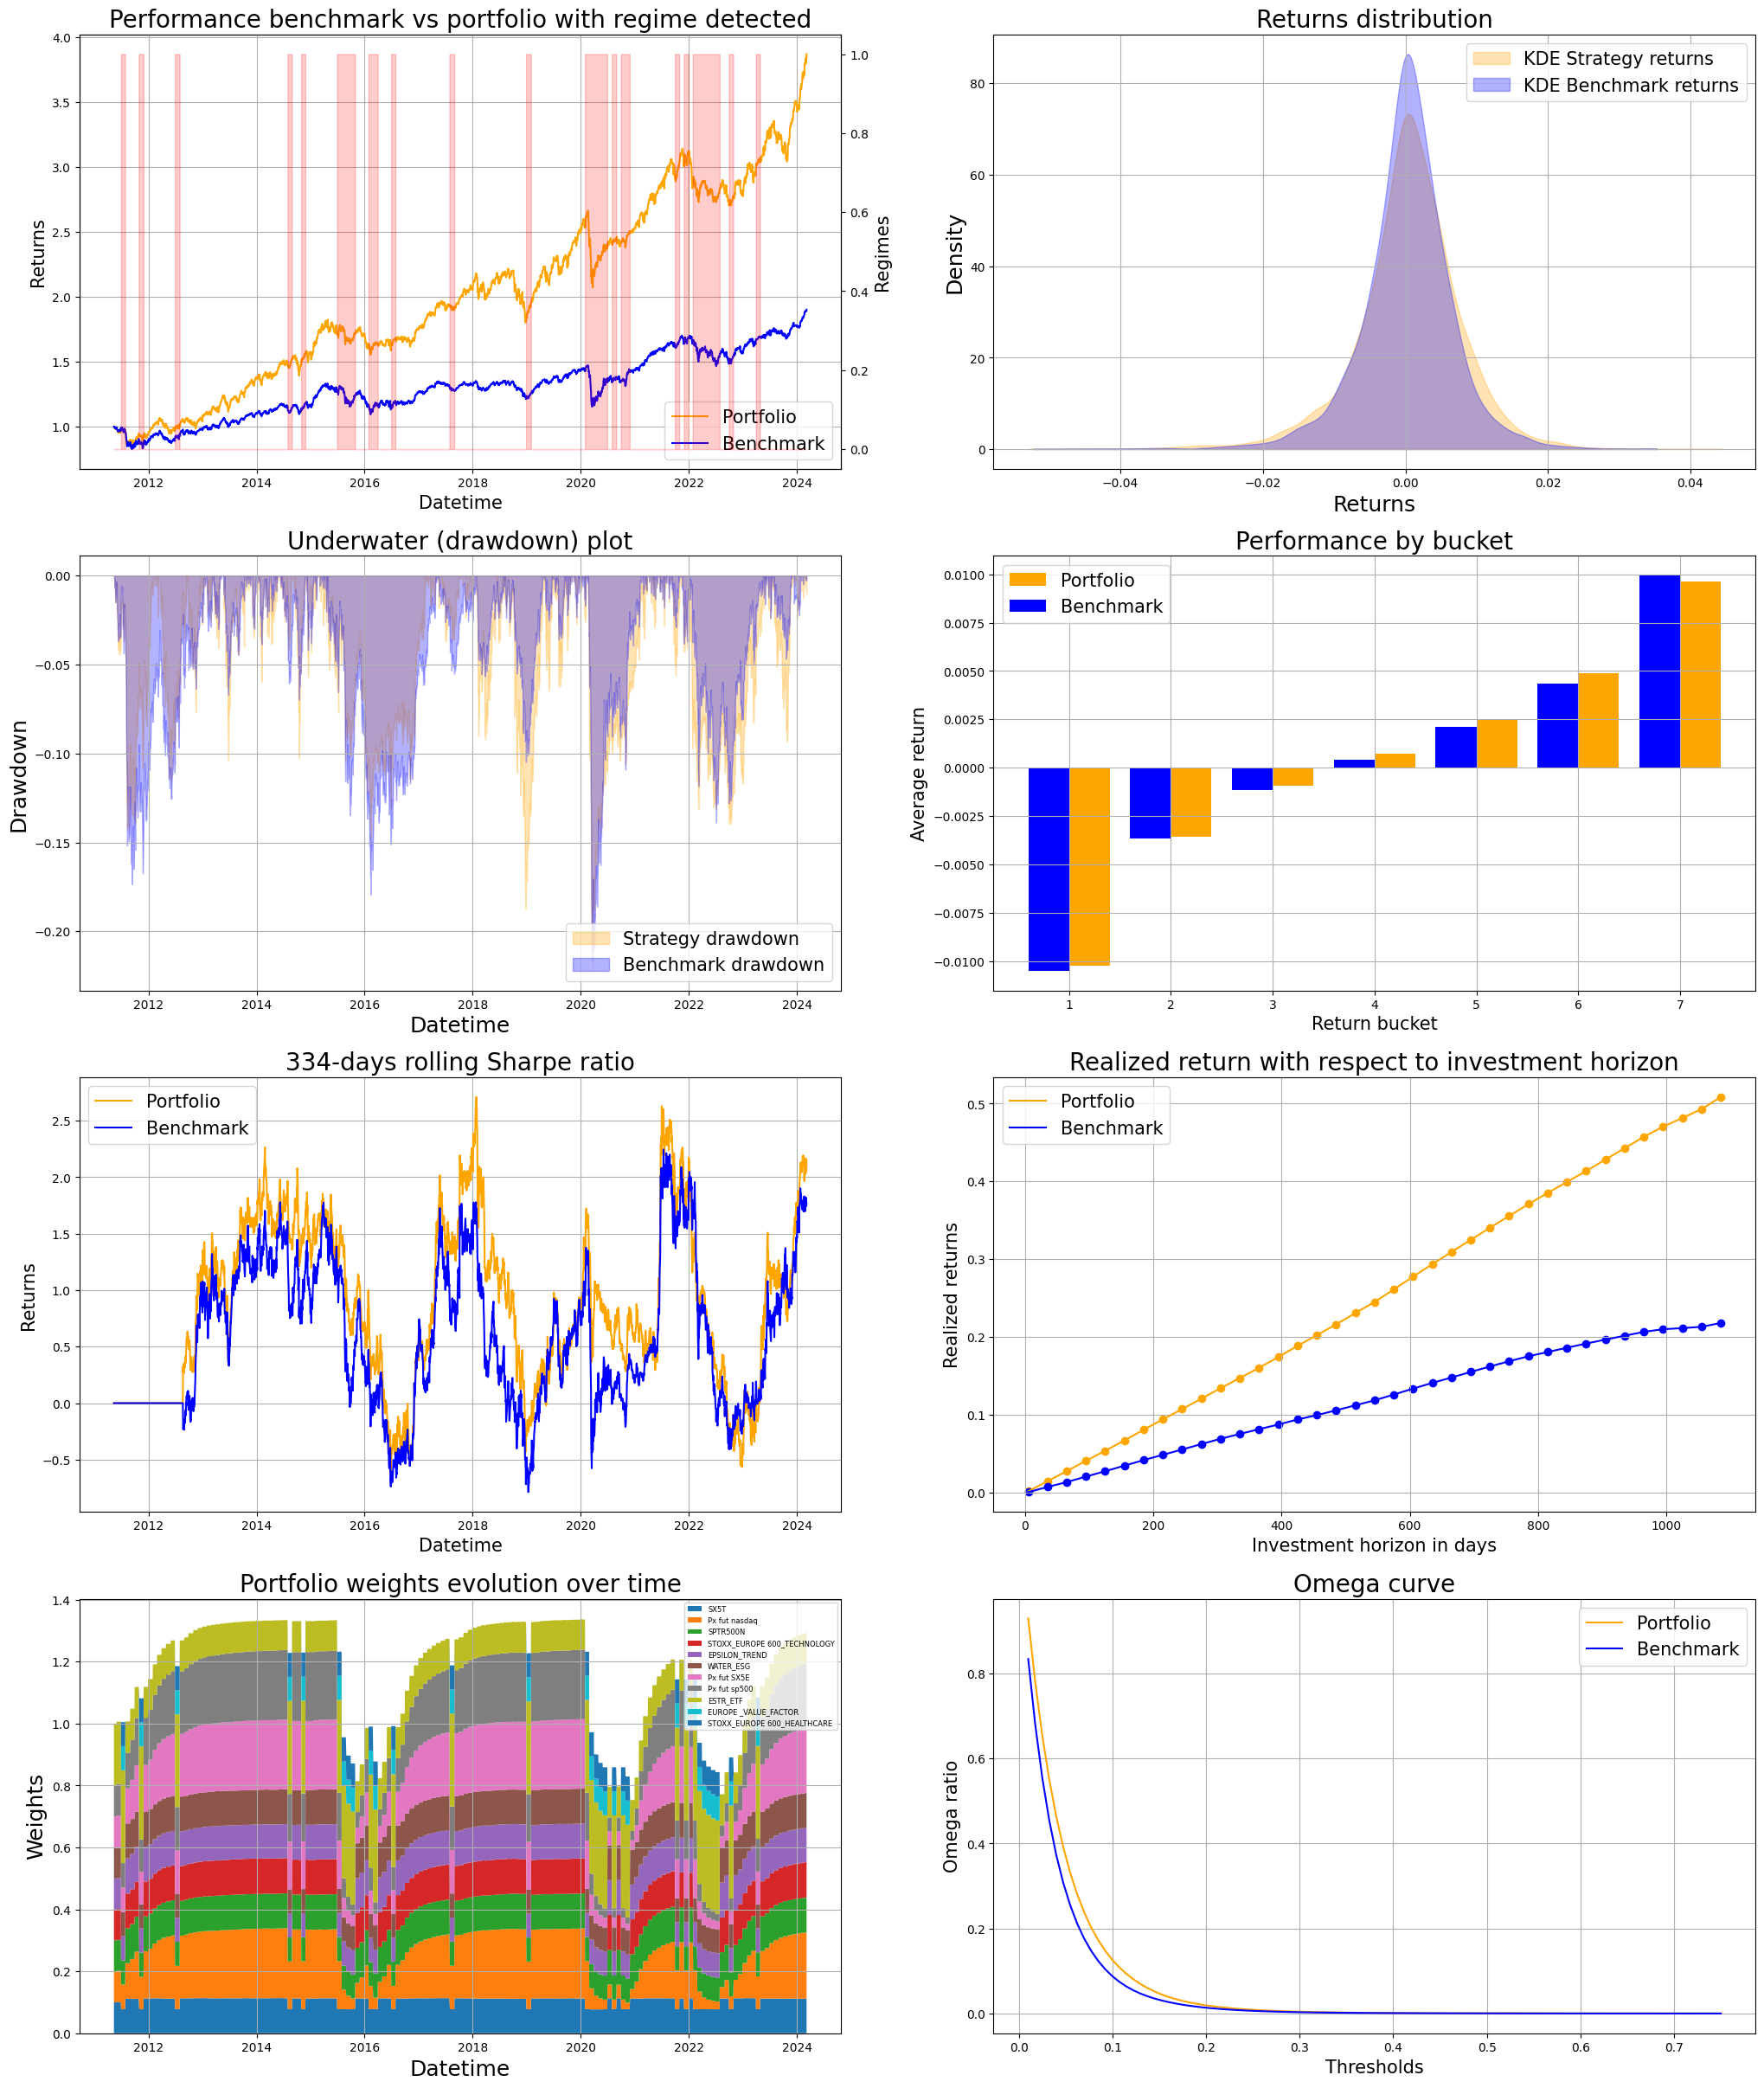

In [22]:
bk_tester = Backtester(
    universe_obj=Universe(market_column="SX5T", keep_only_benchmark_universe=False),
    benchmark_returns=bench_obj.benchmark_returns,
)

(
    ptf_and_bench,
    ptf_weights_equal_weight,
    regimes,
    metrics_df,
) = bk_tester.run_backtest(
    rebalance_frequency=RebalanceFrequencyEnum.MONTH_END,
    regime_frequency=RebalanceFrequencyEnum.MONTH_END,  # .BI_MONTHLY,
    market_regime_model=RegimeDetectionModels.HIDDEN_MARKOV_MODEL,
    risk_on_beta=2,  # stock exposure target in a risk_on regime
    risk_on_lambda_convergence=50,  # Speed of convergence
    risk_off_beta=0.2,  # stock exposure target in a risk_off regime
    risk_off_lambda_convergence=10,  # Speed of convergence
    verbose=False,
    plot_performance=True,
)

## Annual realized performance

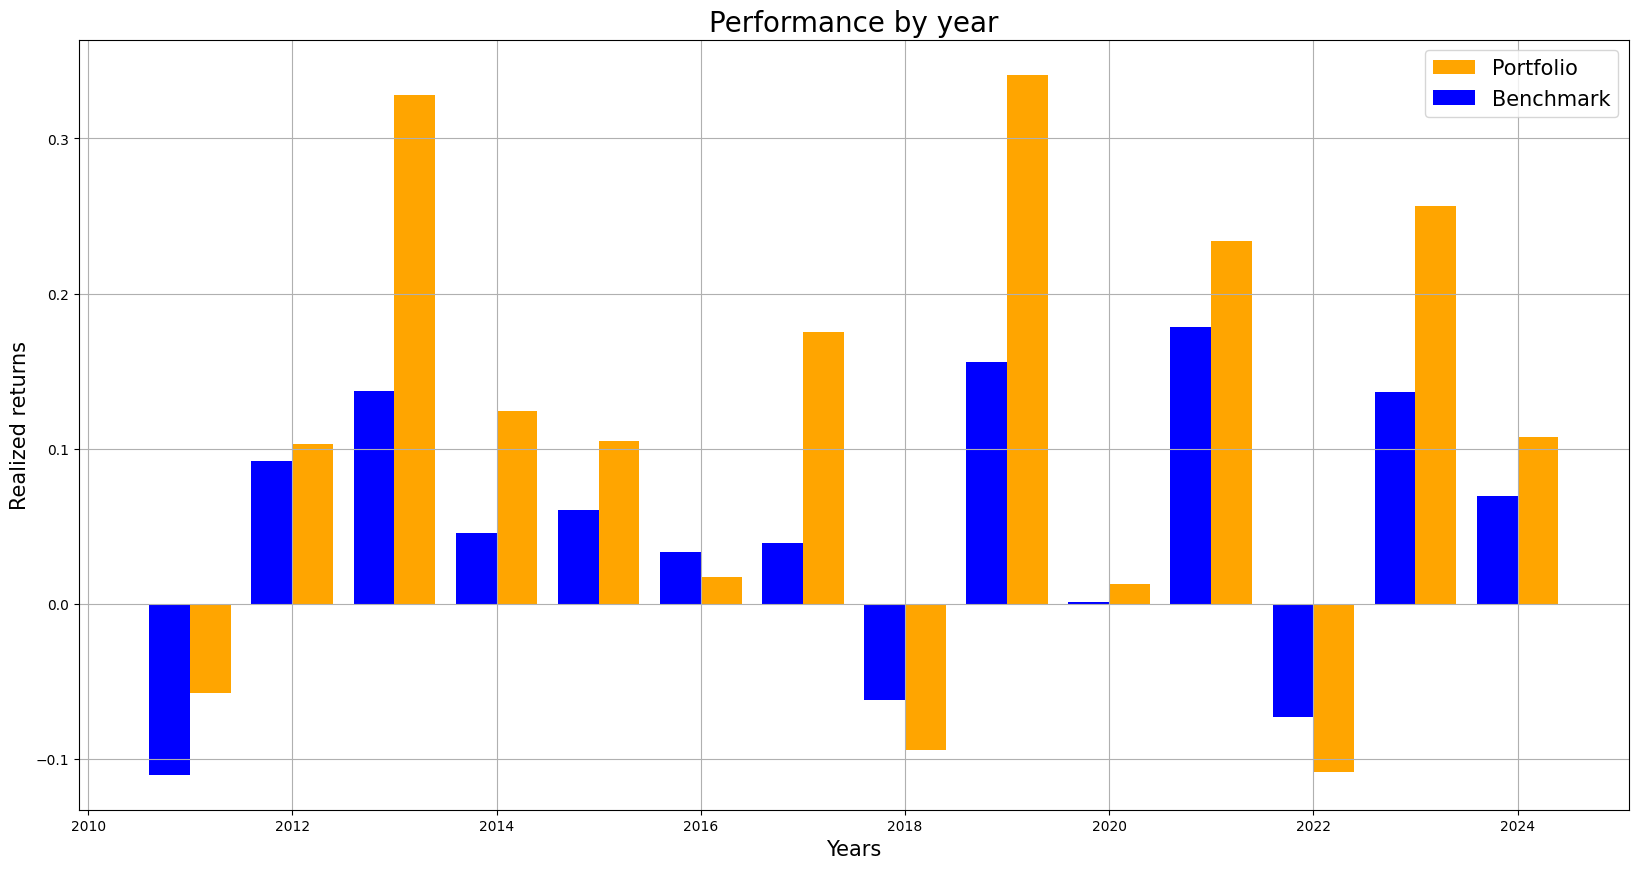

In [37]:
def annual_perf(year_returns: pd.Series) -> float:
    return (1 + year_returns).prod()-1


annual_returns = ptf_and_bench.groupby(by=[ptf_and_bench.index.year]).agg(
    {"strategy_returns": annual_perf, "returns": annual_perf}
).reset_index().rename(columns={'index':'years'})
_, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.bar(
    annual_returns.years + 0.2,
    annual_returns.strategy_returns,
    0.4,
    color="orange",
    label="Portfolio",
)
ax.bar(
    annual_returns.years - 0.2,
    annual_returns.returns,
    0.4,
    color="blue",
    label="Benchmark",
)
ax.set_xlabel("Years", fontsize=15)
ax.set_ylabel("Realized returns", fontsize=15)
ax.set_title(f"Performance by year", fontsize=20)
ax.grid()
ax.legend(fontsize=15)


## Worst periods analysis 

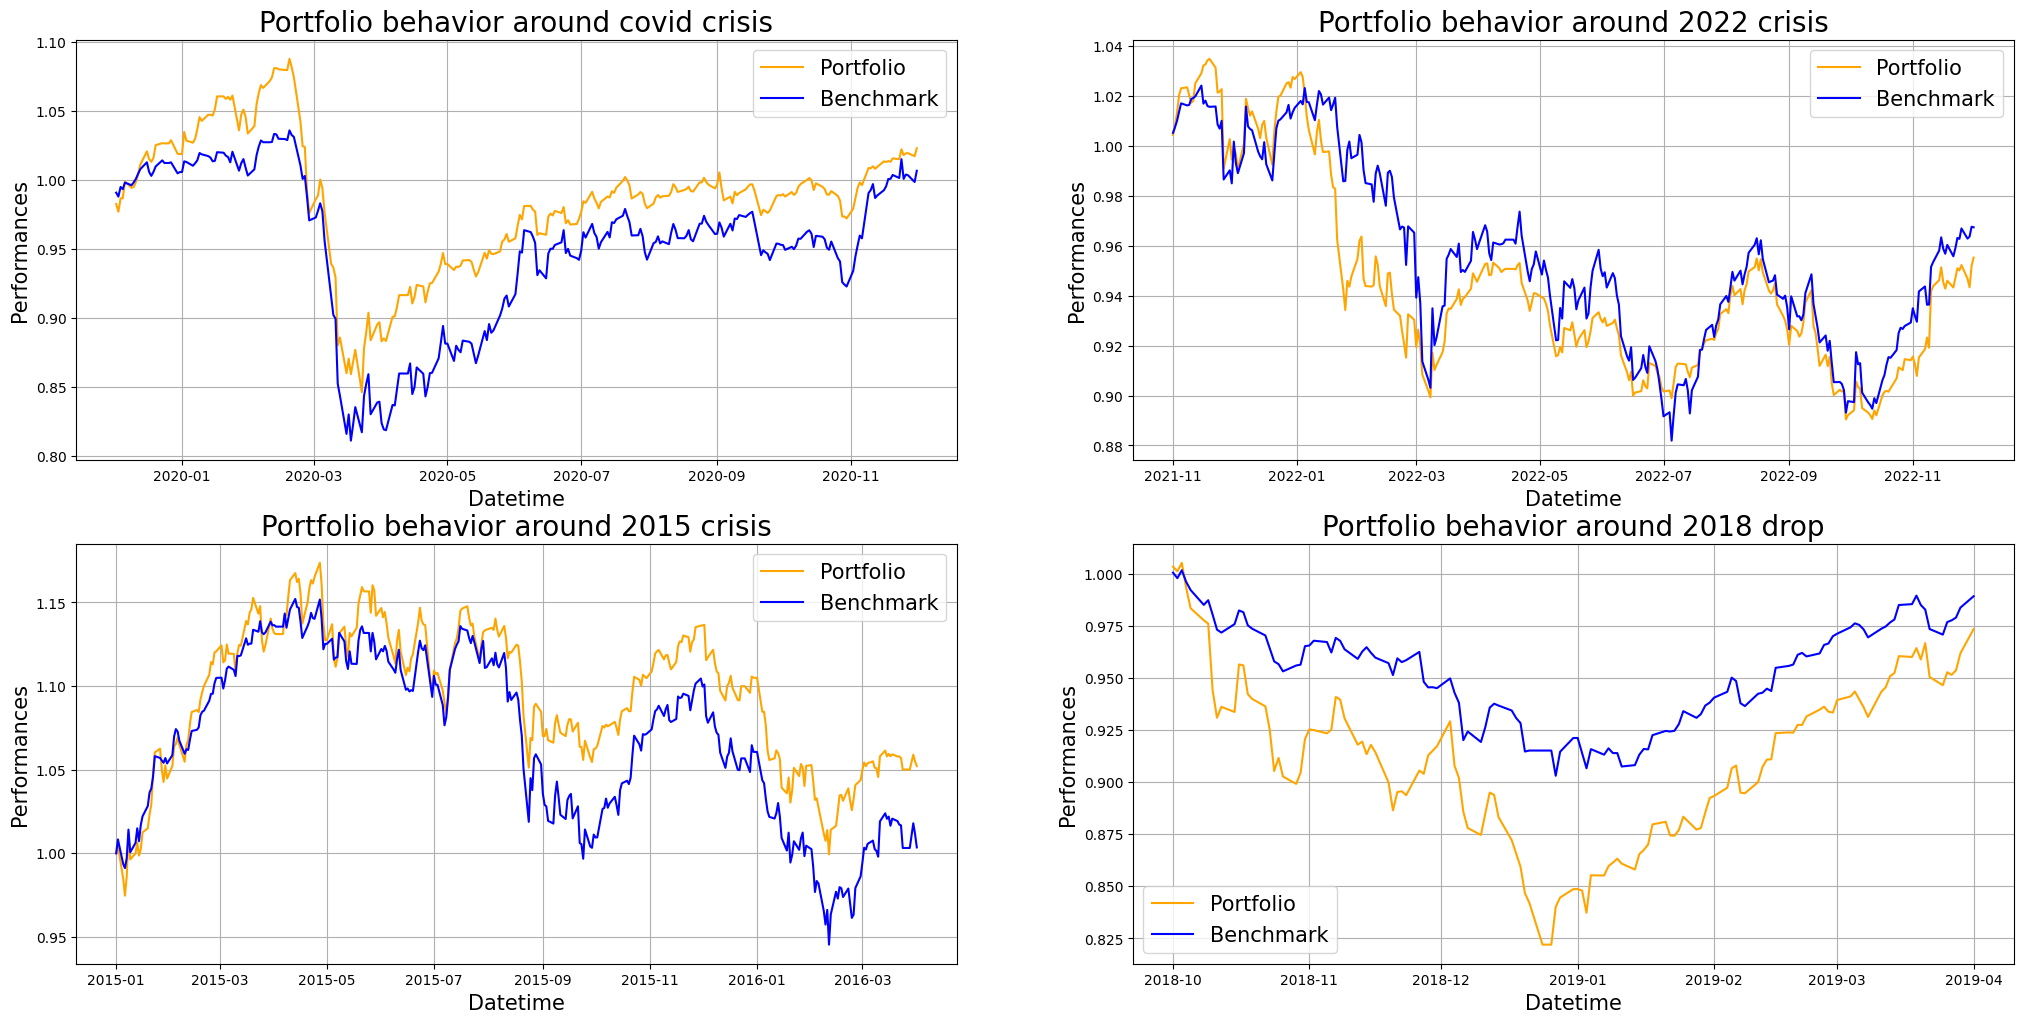

In [59]:



fig, ax = plt.subplots(2, 2, figsize=(25, 12))

covid_ptf_and_bench = (ptf_and_bench.loc["2019-12-01":"2020-12-01"][["strategy_returns","returns"]]+1).cumprod()
ax[0,0].plot(covid_ptf_and_bench.index, covid_ptf_and_bench.strategy_returns,  color="orange", label="Portfolio")
ax[0,0].plot(covid_ptf_and_bench.index, covid_ptf_and_bench.returns,  color="blue",label="Benchmark")
ax[0,0].set_xlabel("Datetime", fontsize=15)
ax[0,0].set_ylabel("Performances", fontsize=15)
ax[0,0].set_title(
    f"Portfolio behavior around covid crisis", fontsize=20
)
ax[0,0].grid()
ax[0,0].legend(fontsize=15)

crisis_2022_ptf_and_bench = (ptf_and_bench.loc["2021-11-01":"2022-12-01"][["strategy_returns","returns"]]+1).cumprod()
ax[0,1].plot(crisis_2022_ptf_and_bench.index, crisis_2022_ptf_and_bench.strategy_returns,  color="orange", label="Portfolio")
ax[0,1].plot(crisis_2022_ptf_and_bench.index, crisis_2022_ptf_and_bench.returns,  color="blue",label="Benchmark")
ax[0,1].set_xlabel("Datetime", fontsize=15)
ax[0,1].set_ylabel("Performances", fontsize=15)
ax[0,1].set_title(
    f"Portfolio behavior around 2022 crisis", fontsize=20
)
ax[0,1].grid()
ax[0,1].legend(fontsize=15)

crisis_2016_ptf_and_bench = (ptf_and_bench.loc["2015-01-01":"2016-04-01"][["strategy_returns","returns"]]+1).cumprod()
ax[1,0].plot(crisis_2016_ptf_and_bench.index, crisis_2016_ptf_and_bench.strategy_returns,  color="orange", label="Portfolio")
ax[1,0].plot(crisis_2016_ptf_and_bench.index, crisis_2016_ptf_and_bench.returns,  color="blue",label="Benchmark")
ax[1,0].set_xlabel("Datetime", fontsize=15)
ax[1,0].set_ylabel("Performances", fontsize=15)
ax[1,0].set_title(
    f"Portfolio behavior around 2015 crisis", fontsize=20
)
ax[1,0].grid()
ax[1,0].legend(fontsize=15)

drop_2018_ptf_and_bench = (ptf_and_bench.loc["2018-10-01":"2019-04-01"][["strategy_returns","returns"]]+1).cumprod()
ax[1,1].plot(drop_2018_ptf_and_bench.index, drop_2018_ptf_and_bench.strategy_returns,  color="orange", label="Portfolio")
ax[1,1].plot(drop_2018_ptf_and_bench.index, drop_2018_ptf_and_bench.returns,  color="blue",label="Benchmark")
ax[1,1].set_xlabel("Datetime", fontsize=15)
ax[1,1].set_ylabel("Performances", fontsize=15)
ax[1,1].set_title(
    f"Portfolio behavior around 2018 drop", fontsize=20
)
ax[1,1].grid()
ax[1,1].legend(fontsize=15)

# Analyzing the beta (stock exposure to the SX5T and S&P500 using futures)

In this section we show the evolution of the dynamics beta across time for the different regimes. As we selected a different convergence speed in the two regime it is normal to have different convergence speed.


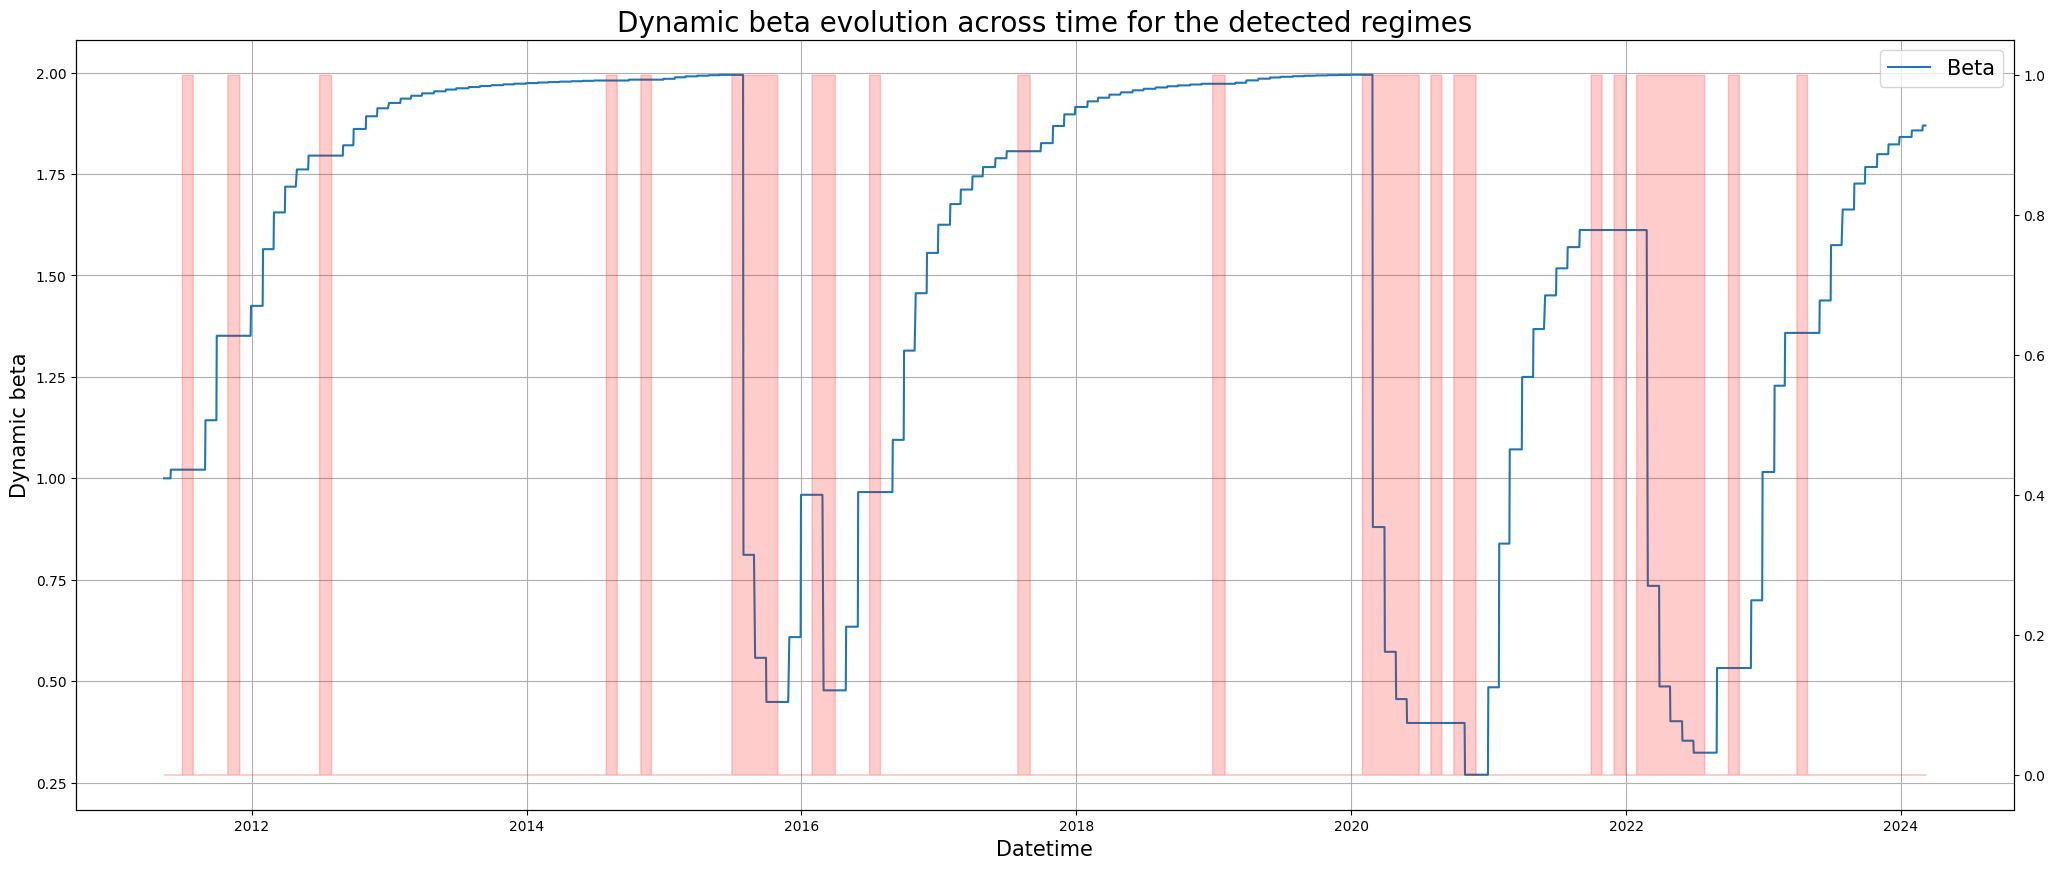

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))


ax.plot(regimes.index, regimes.next_beta, label="Beta")
ax_l = ax.twinx()
ax_l.fill_between(
    regimes.index,
    regimes["Regime"],
    alpha=0.2,
    color="red",
    step="pre",
)
ax_l.set_xlabel("Market regime (0=bull, 1=bear)", fontsize=15)
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Dynamic beta", fontsize=15)
ax.set_title(
    f"Dynamic beta evolution across time for the detected regimes", fontsize=20
)
ax.grid()
ax.legend(fontsize=15)

# Ex-post regime & performance analysis

Chart performance of indices during the risk off and risk on period. The online version of the algorithm clearly catch the covid, the 2015 and 2022 drops


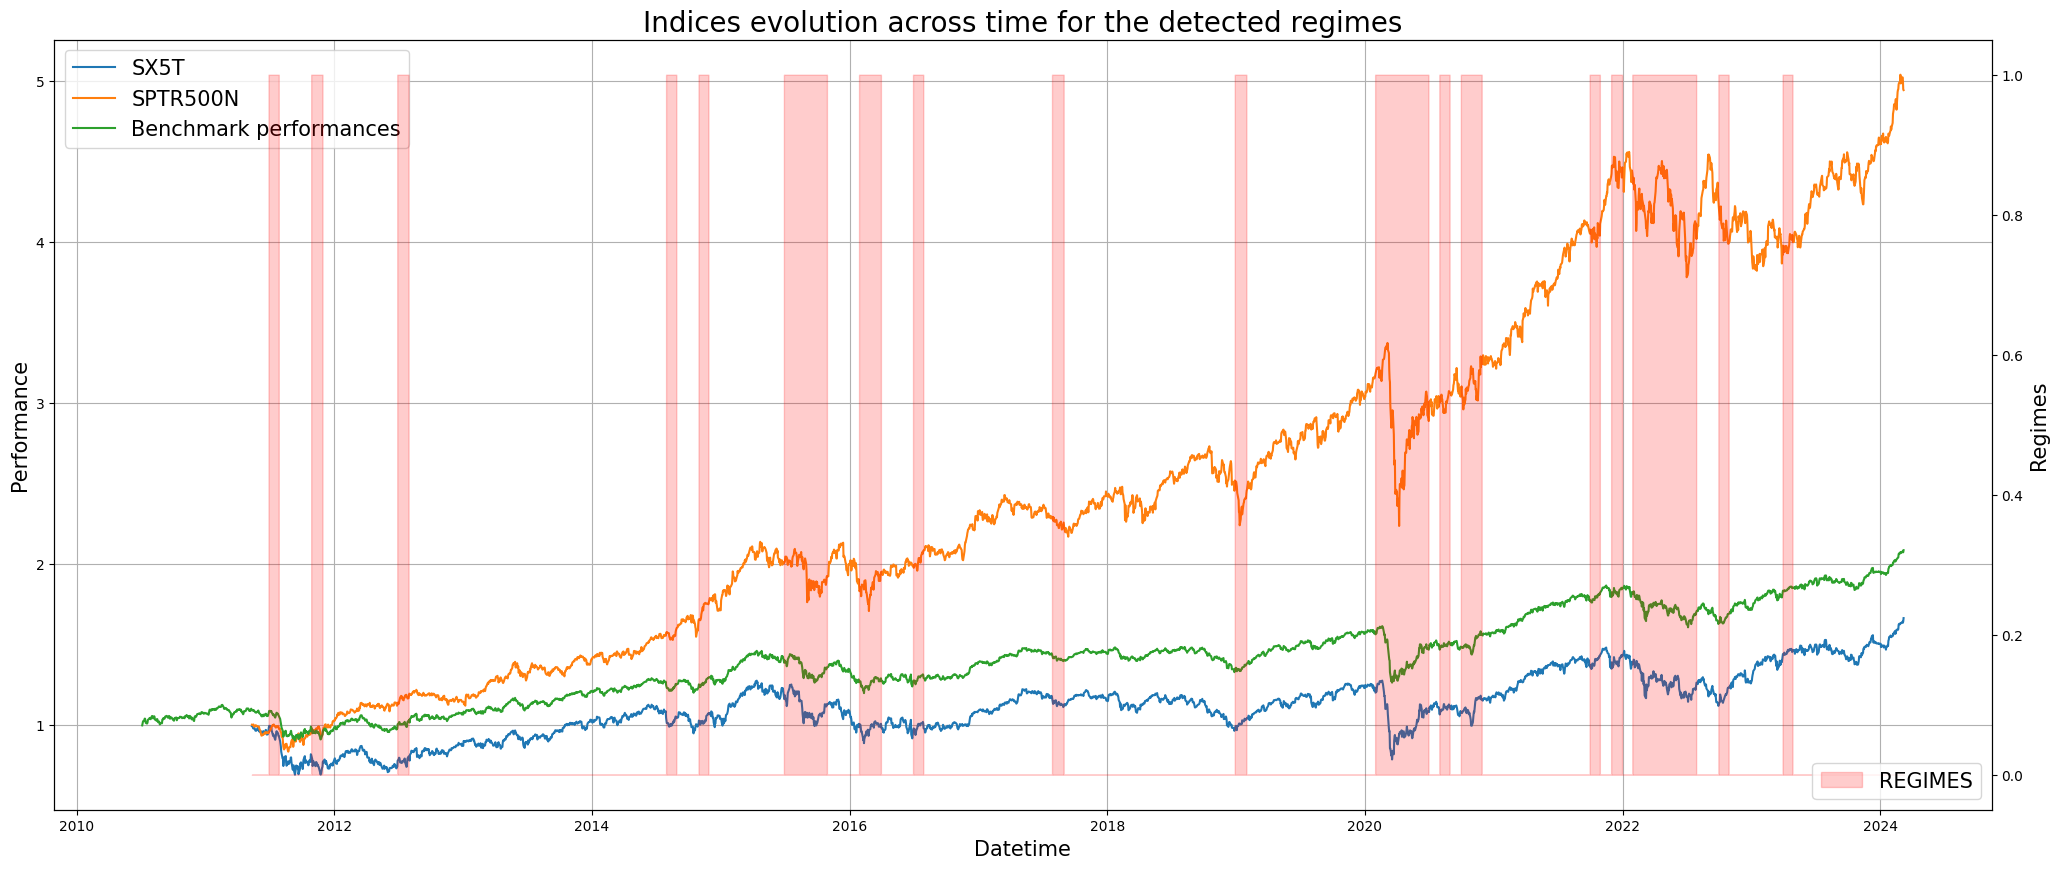

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
universe_data = universe_df.iloc[20:].copy()
universe_data["REGIMES"] = regimes["Regime"]

ax.plot(universe_data.index, (universe_data.SX5T + 1).cumprod(), label="SX5T")
ax.plot(universe_data.index, (universe_data.SPTR500N + 1).cumprod(), label="SPTR500N")
ax.plot(
    bench_obj.benchmark_perf.index,
    bench_obj.benchmark_perf,
    label="Benchmark performances",
)
ax_l = ax.twinx()
ax_l.fill_between(
    universe_data.index,
    universe_data["REGIMES"],
    alpha=0.2,
    color="red",
    step="pre",
    label="REGIMES",
)
ax_l.set_xlabel("Market regime (0=bull, 1=bear)", fontsize=15)
ax.set_xlabel("Datetime", fontsize=15)
ax_l.set_ylabel("Regimes", fontsize=15)
ax.set_ylabel("Performance", fontsize=15)
ax.set_title(f"Indices evolution across time for the detected regimes", fontsize=20)
ax.grid()
ax_l.legend(fontsize=15, loc="lower right")
ax.legend(fontsize=15)

Average (ex-post) annualized return during the risk on regime.


In [25]:
(universe_data[universe_data["REGIMES"] == 0].mean() * 252).drop(
    index="REGIMES"
).sort_values()

ESTR_ETF                       0.002798
EPSILON_TREND                  0.029717
SX5T                           0.050054
Px fut SX5E                    0.051907
EUROPE _VALUE_FACTOR           0.059887
STOXX_EUROPE 600_HEALTHCARE    0.092806
Px fut sp500                   0.098310
WATER_ESG                      0.102143
STOXX_EUROPE 600_TECHNOLOGY    0.123528
Px fut nasdaq                  0.148646
SPTR500N                       0.163018
dtype: float64

Average (ex-post) annualized return during the risk off regime.


In [26]:
(universe_data[universe_data["REGIMES"] == 1].mean() * 252).drop(
    index="REGIMES"
).sort_values()

ESTR_ETF                      -0.001519
SPTR500N                       0.019556
EUROPE _VALUE_FACTOR           0.084249
SX5T                           0.092499
EPSILON_TREND                  0.092626
Px fut SX5E                    0.099472
WATER_ESG                      0.140609
STOXX_EUROPE 600_HEALTHCARE    0.156837
STOXX_EUROPE 600_TECHNOLOGY    0.167719
Px fut sp500                   0.185390
Px fut nasdaq                  0.271831
dtype: float64